## CSB: Data Science Internship Assignment
<p> Predictive modelling for a 'Rare' event in the customer experience journey. <br>  All resulting Precision-recall Curves in accompanying folder and some intermediate results in accompanying excel sheet.<br>
    <b> Data and Problem Description</b><br></p>

* The data provided is time-series for various accounts along with a label that signifies whether an intervention was required for the account. ~60 features are provided that I'm assuming are metrics that have something to do with the account/customer interaction with certain features. Possible that as interaction goes down below a threshold. the customer/account is at risk of leaving. So the intervention might be required to get the interaction back up ? 

* <b> Imbalanced Binary Classification Problem - Evaluation Metrics (Precision Recall, F1 Score)</b><br>
 Since the Positive Label is extremely scarce (~1%, minority class), Accuracy can be misleading. Precision, Recall are more suitable metrics. I'll be using the F1-score (their harmonic mean) and the Precision-Recall curve to evaluate my models. <br>
 
* <b> Data already Cleaned, Pre-processed </b>, was mentioned on stream that the data doesn't need to be normalised/standardised and all columns seem to be intact, in suitable data types. Had to scale it for the ANN.

<b>Approach</b>
1. Simple Naive Method - Feature Selection and Classification Models. Not sequence models, don't directly exploit time-series.
 * <b> Dealing with the Imbalance - Weighted cost functions </b>
 Weighing the models by using inverse frequency of the classes. Undersampling the data resulted in lower performance.
 * <b> Prioritizing higher Recall </b> since the event is rare and needs intervention, it'll be better to proritize  recall rate even if a lower precision results in a few false positives, as we don't want to miss the actual accounts that need intervention.
 * <b> Feature Selection using Multivariate EDA and Random-Forest on entire feature set</b>
 *  Split the training data into train and validation by account ID to avoid leak, 62 % in train, 38 % in validation, gives around .94% positive class in both.
 * <b> Simple Classification Models like Logistic Regression, Random Forest Classifier, XGBoost Classifier </b> used and tuned on the selected features from training and validation data before final P-R curve on Test set. Tried a simple ANN but results in low training performance (possibly not enough data, loss not going down, difficult to tune), SVCs were extremely slow to train.
 * <b> Tried a Voting classifer </b> ensemble, doesn't improve performance. Better tuning of classifiers needed.
 
2. Time-Series based approach - Performed some exploratory analysis of the overall time series and by accounts. No modelling done.

In [80]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math
from sklearn.linear_model import LogisticRegression
from scipy.stats import pearsonr
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import f1_score, classification_report, plot_precision_recall_curve, precision_recall_curve
from sklearn.preprocessing import StandardScaler
from itertools import combinations
from keras.models import Sequential 
from keras.layers import Dense, Dropout
from keras.utils import np_utils

pd.set_option('display.max_rows', 200)
pd.options.mode.chained_assignment = None

#### Helper Functions 
A few helper functions that are used to split the data properly by account ID, check if any overlapping accounts exist between two sets and to plot the precision-recall curves for a list of models.

In [3]:
def overlap_sanity_check(x_train, x_test):
    '''Checks if unique accounts IDs overlap in the sets.
    '''
    for i in x_train.index.unique():
        if i in x_test.index.unique():
            print('Overlap')
            break

In [4]:
def train_test_split_acc(df, test_size = 0.38):
    ''' Splits the DF (includes labels) into Train, validation sets by AccountID.
    Default .38 selected as it keeps the distribution of the labels similar in both sets.
    '''
    df.sort_index(inplace=True)
    split_acc = df.index.unique()[math.ceil((len(df.index.unique())* test_size))]
    x_train = df.loc[df.index > split_acc]
    x_test = df.loc[df.index <= split_acc]
    y_train = x_train['Label']
    y_test = x_test['Label']
    x_train.drop(['Label'], axis = 1, inplace = True)
    x_test.drop(['Label'], axis = 1, inplace = True)
    print(f'Split of Labels in train set \n{y_train.value_counts()/len(y_train)}')
    print(f'Split of Labels in test set \n{y_test.value_counts()/len(y_test)}')
    overlap_sanity_check(x_train, x_test)
    return x_train, x_test, y_train, y_test

In [5]:
def plot_pr_cuves(clf_list, x, y, title):
    ''' Takes in a list of initialised and fitted classifier instances
    and the DF and labels used for validation.
    save: String for Saving Graph in /Curves
    '''
    fig,ax = plt.subplots()
    fig.set_figheight(6)
    fig.set_figwidth(12)
    for clf in clf_list:
          plot_precision_recall_curve(clf, x.values, y, ax = ax)
    plt.savefig(f'Curves/{title}.jpg')
    plt.title(title)
    plt.show()

## 1. Naive Approach - A. Baseline Models
1. Baseline Models uisng All Features and balanced weights, plotting Preision-Recall curve on the validation set . Using Random Forest's feature importance for lead on Important Features.
2. So, <b>Baseline Featureset - all features.</b>

In [83]:
# Data indexed by account ID.
train = pd.read_csv('Train_Set.csv', index_col=0)
test = pd.read_csv('Test_Set.csv', index_col=0)
# Data Balance
train.Label.value_counts()/len(train)

0    0.990619
1    0.009381
Name: Label, dtype: float64

In [84]:
train.head(5)

,week_start_date,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,...,feature54,feature55,feature56,feature57,feature58,feature59,feature60,feature61,feature62,Label
account_id,,,,,,,,,,,,,,,,,,,,,
100559.0,2018-09-03,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
101026.0,2018-09-03,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
101026.0,2018-09-10,0.0,0.0,86.666667,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
101026.0,2018-09-17,0.0,0.0,-0.076046,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
101026.0,2018-09-24,0.0,0.0,-0.987654,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [85]:
# Data balance on split train, validation sets.
x_train, x_test, y_train, y_test = train_test_split_acc(train, test_size=0.38)

Split of Labels in train set 
0    0.990644
1    0.009356
Name: Label, dtype: float64
Split of Labels in test set 
0    0.990585
1    0.009415
Name: Label, dtype: float64


In [86]:
# Dropping time-series week start markers. 
x_train.drop(['week_start_date'], axis = 1, inplace=True)
x_test.drop(['week_start_date'], axis = 1, inplace=True)
# Saving baseline feature set 
baseline_features = x_train.columns.to_list()

In [9]:
# Calculating Class Weights.
class_weight = y_train.value_counts()[0]/y_train.value_counts()[1]

In [25]:
# Initialising Classifiers with gridsearch optimised parameters, log-reg wont converge with all features
# f-1 score on train dataset. Scores when optimising in excel sheet.

clf_log = LogisticRegression(class_weight={0:1, 1:class_weight}, max_iter = 300)
clf_rf = RandomForestClassifier(n_estimators=150, criterion='gini',
                                max_depth=6, class_weight={0:1, 1:class_weight})
xgb_clf = XGBClassifier(eta = .3, scale_pos_weight = class_weight, max_depth = 6,
                        n_estimators = 300,
                        objective='binary:logistic', learning_rate = .5, eval_metric = 'aucpr')
# saving list of classifiers 
clf_list = [clf_log, clf_rf, xgb_clf]

clf_log.fit(np.array(x_train), y_train)
clf_rf.fit(np.array(x_train), y_train)
xgb_clf.fit(np.array(x_train), y_train)
print(f'Logistic Regression - {f1_score(y_train, clf_log.predict(np.array(x_train)))}')
print(f'Random Forest - {f1_score(y_train, clf_rf.predict(np.array(x_train)))}')
print(f'XGBoost - {f1_score(y_train, xgb_clf.predict(np.array(x_train)))}')

/home/desktop-anand/.local/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Logistic Regression - 0.27580511973575556
Random Forest - 0.34118169702354506
XGBoost - 0.4917660420215787


#### Validation Set Metrics
Both recall and accuracy are low,will try feature selection and optimising the hyperparameters classifiers.

In [32]:
y_pred_log = clf_log.predict(np.array(x_test))
y_pred_rf = clf_rf.predict(np.array(x_test))
y_pred_xgb = xgb_clf.predict(np.array(x_test))
print('Logistic Regression\n', classification_report(y_test, y_pred_log))
print('RandomForestClassifier\n', classification_report(y_test, y_pred_rf))
print('XGBClassifier\n',classification_report(y_test, y_pred_xgb))

Logistic Regression
               precision    recall  f1-score   support

           0       0.99      0.98      0.99     47134
           1       0.16      0.45      0.24       448

    accuracy                           0.97     47582
   macro avg       0.58      0.71      0.61     47582
weighted avg       0.99      0.97      0.98     47582

RandomForestClassifier
               precision    recall  f1-score   support

           0       0.99      0.99      0.99     47134
           1       0.24      0.43      0.31       448

    accuracy                           0.98     47582
   macro avg       0.62      0.71      0.65     47582
weighted avg       0.99      0.98      0.98     47582

XGBClassifier
               precision    recall  f1-score   support

           0       0.99      0.99      0.99     47134
           1       0.28      0.44      0.34       448

    accuracy                           0.98     47582
   macro avg       0.64      0.71      0.67     47582
weighted avg  

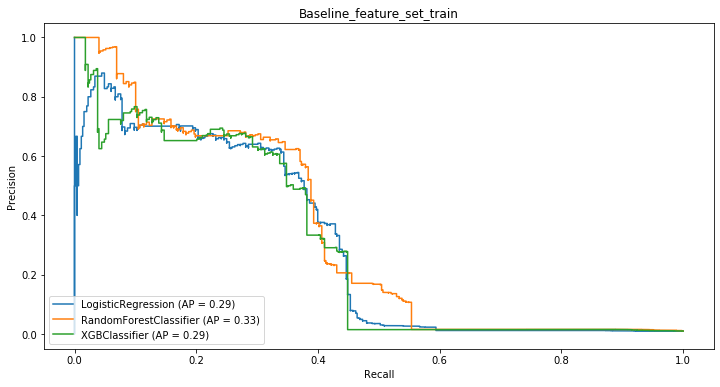

In [13]:
plot_pr_cuves(clf_list, x_test, y_test,title = 'Train_Baseline_feature_set')

#### Important Features from Random Forest -  (10 most important features)

In [33]:
## Get feature importance from RF
feat_imp = pd.DataFrame(index=x_train.columns , data = clf_rf.feature_importances_, columns=['Feature_Importance'])
feat_imp.sort_values(by = 'Feature_Importance', axis = 0, ascending=False, inplace = True)
imp_features = feat_imp.index.to_list()[:10]

## Multivariate EDA, Data Interaction and Feature Selection

### Perason's Correlation Between Features 
1. Finding and plotting the features with highest absolute correlations between them, along with the positive labels in yellow. 
2. The most correlated features don't seem to have much discriminating power, most likely adding noise,  can be ignored.

In [15]:
## Getting the highest absolute correlations between features. Get pair of features, find correlations for each pair,
# store in list along with feature names

temp = train.drop(['Label', 'week_start_date'] , axis = 1).copy()
temp_corr = temp.corr()

corr_list = []
pair_feat = []
# Reduced complexity from two nested for loops uisng itertools combinations.
for i, item in enumerate(list(combinations(temp.columns.to_list(),2))):
    pair_feat.append(item)
    
for item in pair_feat:
    corr_list.append([item[0], item[1], np.abs(temp_corr.at[item[0], item[1]])])

corr_array = np.array(corr_list)
corr_array = corr_array[corr_array[:,2].argsort()][::-1]
#corr_array[104:124]

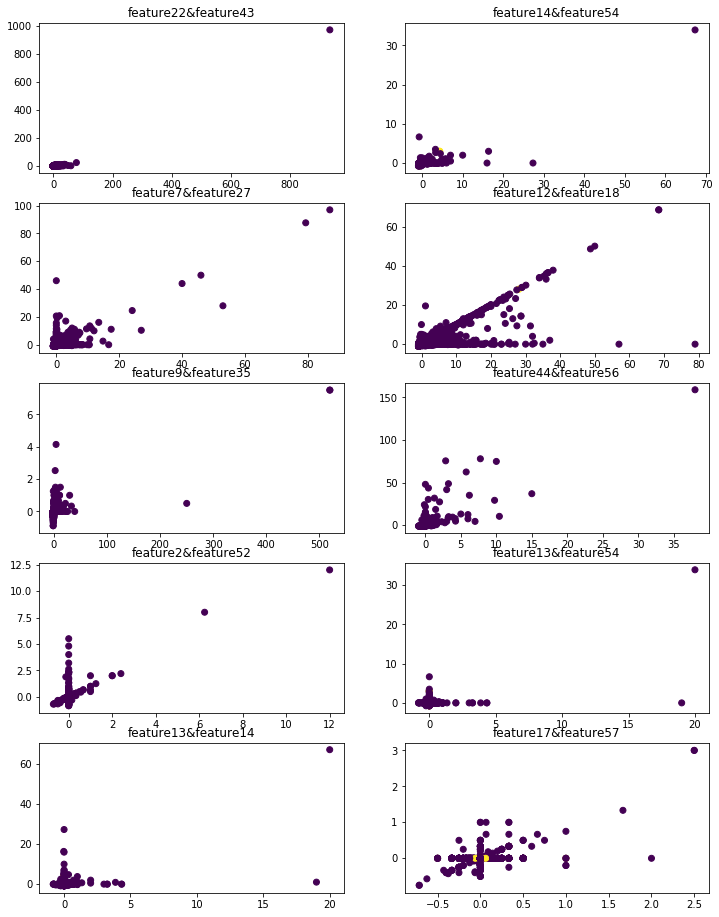

In [36]:
fig = plt.figure()
fig.set_figheight(16)
fig.set_figwidth(12)
for i, item in enumerate(corr_array[104:114]):
    ax = fig.add_subplot(5, 2, i+1)
    plt.scatter(x = train[item[0]].values, y = train[item[1]].values, c = train.Label.values)
    ax.set_title(item[0] + '&' + item[1])

## Pearson's correlation of features with Label 
1. Although the pearson's correlation for the continuous variables and categorical target is not strictly meaningful, in practise it can be useful. <br> 
2. The skew can also affect the correlation, checked later with the majority class undersampled. Tried to model with undersampled data but resulted in worse performance that weighted cost.
3. Features 15, 16, 37 seem to be highly correlated with the label.<br>
<b>Feature Set 1 (3 features with highest Correlation with label)</b>

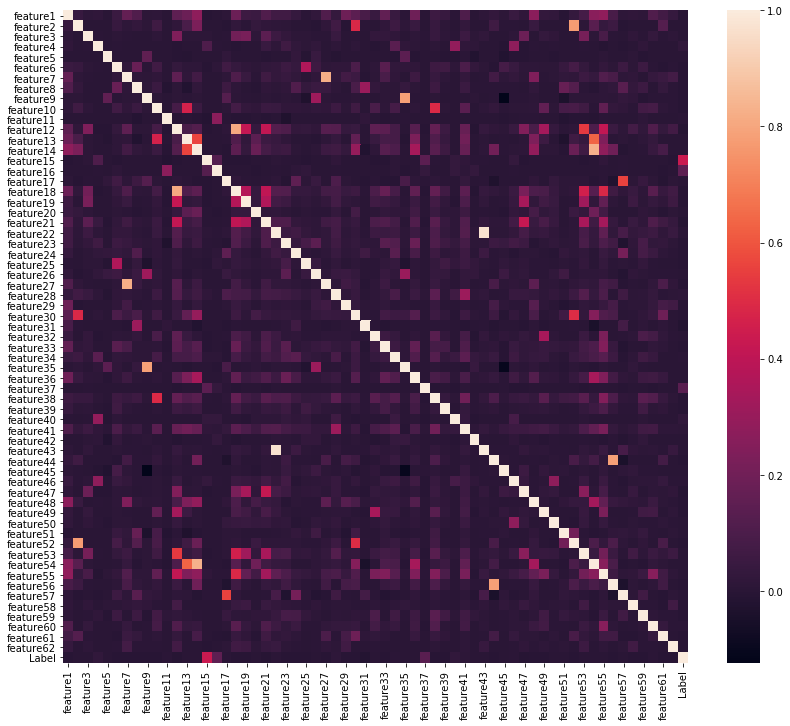

In [16]:
temp = train.copy()
#temp.drop(['Label'], axis =1, inplace = True)
plt.figure(figsize=(14,12))
sns.heatmap(temp.corr(method='pearson'))
plt.show()

### Randomly Undersampling Majority Class and then checking correlation with label
1. This method is not robust as we're throwing away a lot of data. We can see that as values for certain features  in the sample are just 0, shows up as no correlation with any other features below.
2. The features that appear to be correlated with the labels for this sample are the ones selected from the multivariate EDA below. Those assumptions seems to have been correct.
3. Modelled using undersampled data, lower performance than using all data, graph saved in Curves folder, suffixed undersamplped.

In [17]:
temp = train.copy()
# shuffling the train set before 
temp = temp.sample(frac = 1, random_state = 15)
# getting the same number of samples for majority class, 1076
intervene = temp.loc[temp['Label'] == 1]
no_intervene = temp.loc[temp['Label'] == 0].iloc[:1076]
new_df = pd.concat([intervene, no_intervene ])
# shuffling this new df
new_df = new_df.sample(frac=1)
new_df.Label.value_counts()

1    1076
0    1076
Name: Label, dtype: int64

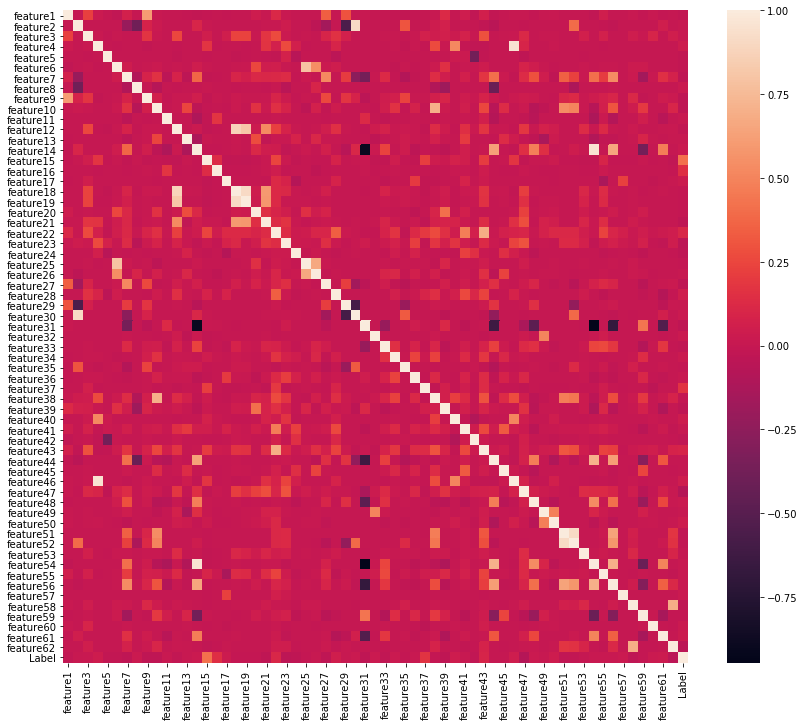

In [18]:
# Now correlations for this balanced subsample. 
plt.figure(figsize=(14,12))
sns.heatmap(new_df.corr(method = 'pearson'))
plt.show()

### Data Interaction of features correlated with label.
1. The yellow points denote the instances where an intervention was required or a label of 1.
2. There is definitely interesting interaction between these features, there is clear distinction between the postive classes in the graphs on the first column.
3. Comparing these plots with the interaction of multiple accounts with features from the livestream, it appears to be that these features cross each other just around the min threshold.
4. These features don't seem to be highly correlated.
2. Interestingly, the useful features are the ones whose interaction have a distinct cross like interaction. The labels turning to 1 somewhat depends on the points being on the outside of the interaction of the points. Can Use this info to find more such interactions(Total 1890 combinations, have to narrow it down).

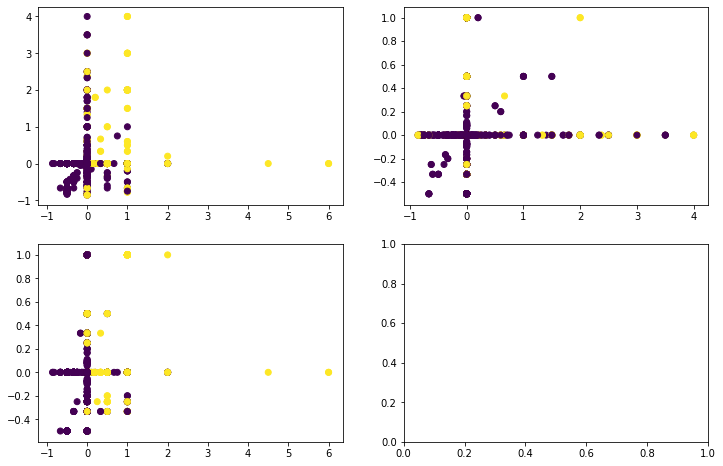

In [27]:
# Correlation of 0.125
fig, ax = plt.subplots(2, 2)
fig.set_figheight(8)
fig.set_figwidth(12)
ax[0,0].scatter(x = train['feature15'].values, y = train['feature16'].values, c = train.Label.values)
# Correlation of 0.0310
ax[0,1].scatter(x = train['feature16'].values, y = train['feature37'].values, c = train.Label.values)
# Correlation of 0.141
ax[1,0].scatter(x = train['feature15'].values, y = train['feature37'].values, c = train.Label.values)
plt.show()

![](multiple_accounts_single_features.png)

## B. Models using only the features most correlated with the label
1. Similar recall to previous model, much improved precision, the curve is also much more stable across the board.

In [102]:
feature_set_1 = ['feature15', 'feature16', 'feature37']

In [35]:
clf_log.fit(np.array(x_train[feature_set_1]), y_train)
clf_rf.fit(np.array(x_train[feature_set_1]), y_train)
xgb_clf.fit(np.array(x_train[feature_set_1]), y_train)
print(f'Logistic Regression - {f1_score(y_train, clf_log.predict(np.array(x_train[feature_set_1])))}')
print(f'Random Forest - {f1_score(y_train, clf_rf.predict(np.array(x_train[feature_set_1])))}')
print(f'XGBoost - {f1_score(y_train, xgb_clf.predict(np.array(x_train[feature_set_1])))}')

Logistic Regression - 0.5463917525773195
Random Forest - 0.5176824680210684
XGBoost - 0.5396078431372549


In [36]:
y_pred_log = clf_log.predict(np.array(x_test[feature_set_1]))
y_pred_rf = clf_rf.predict(np.array(x_test[feature_set_1]))
y_pred_xgb = xgb_clf.predict(np.array(x_test[feature_set_1]))
print('Logistic Regression\n', classification_report(y_test, y_pred_log))
print('RandomForestClassifier\n', classification_report(y_test, y_pred_rf))
print('XGBClassifier\n',classification_report(y_test, y_pred_xgb))

Logistic Regression
               precision    recall  f1-score   support

           0       0.99      1.00      0.99     47134
           1       0.46      0.45      0.45       448

    accuracy                           0.99     47582
   macro avg       0.73      0.72      0.72     47582
weighted avg       0.99      0.99      0.99     47582

RandomForestClassifier
               precision    recall  f1-score   support

           0       1.00      0.99      0.99     47134
           1       0.39      0.49      0.44       448

    accuracy                           0.99     47582
   macro avg       0.69      0.74      0.72     47582
weighted avg       0.99      0.99      0.99     47582

XGBClassifier
               precision    recall  f1-score   support

           0       1.00      0.99      0.99     47134
           1       0.40      0.48      0.44       448

    accuracy                           0.99     47582
   macro avg       0.70      0.74      0.72     47582
weighted avg  

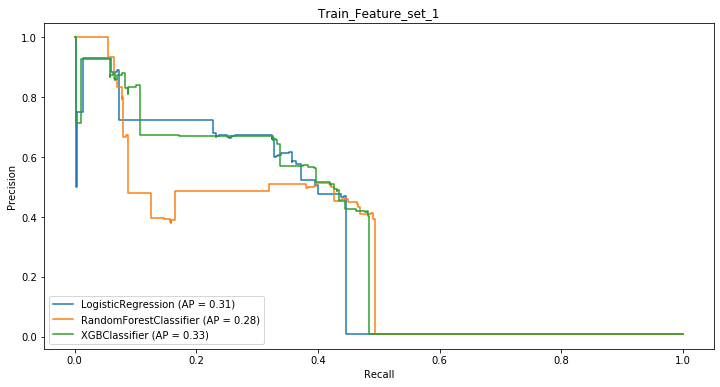

In [37]:
plot_pr_cuves(clf_list, x_test[feature_set_1], y_test,title = 'Train_Feature_set_1')

### Plotting Important features from baseline Random Forest 
1. Interactions of other features shows similar behaviour to the features selected so far, this interaction of the data is seems important.
2. Creating Feature set 2 by combining a few promising features from these interactions and featureset1. 
3. <b>Featureset 2 (7 features). </b> Modelling.
4. Recall increased slightly.

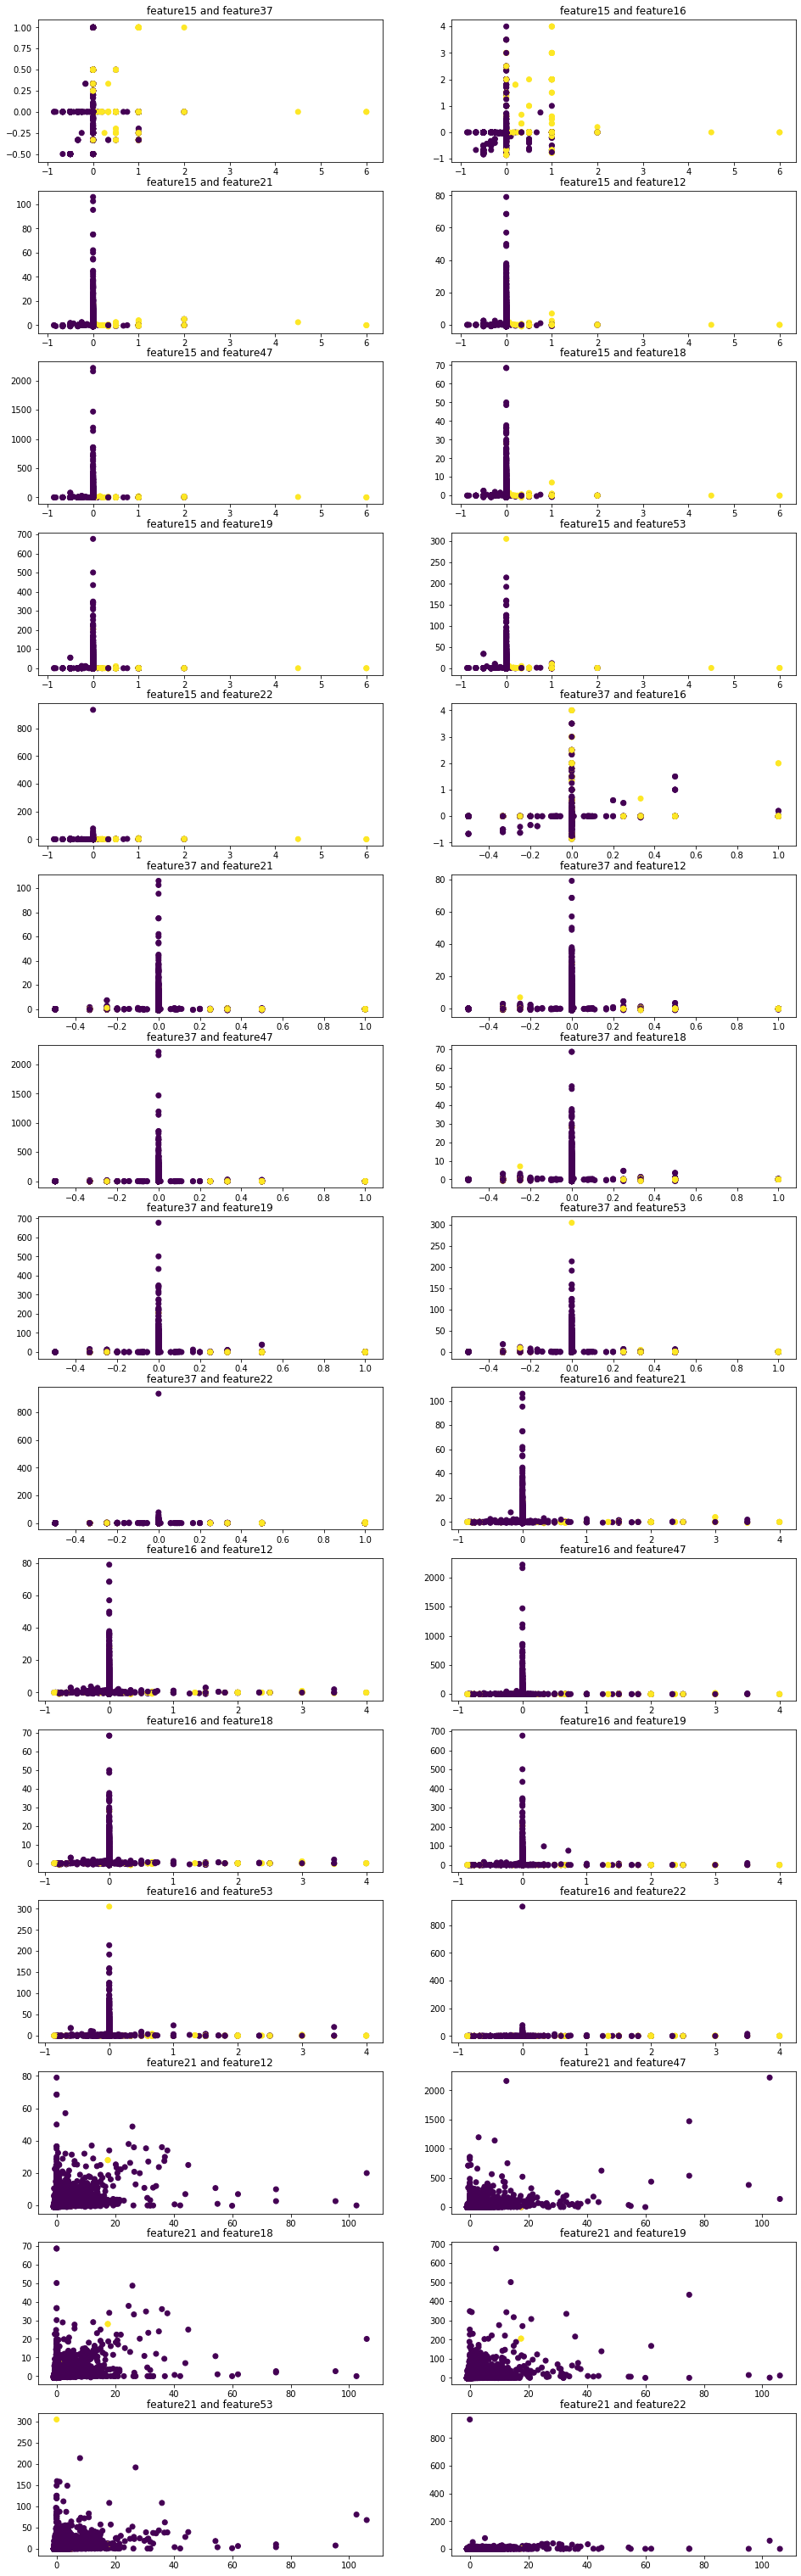

In [57]:
combinations_imp = list(combinations(imp_features, 2))
fig = plt.figure(figsize=(16, 55))
for i, item in enumerate(combinations_imp[:30]):
    ax = fig.add_subplot(15, 2, i+1)
    ax.scatter(x = train[item[0]].values, y = train[item[1]].values, c = train.Label.values)
    ax.title.set_text(f'{item[0]} and {item[1]}')
    
plt.show()

In [26]:
feature_set_2 = ['feature15', 'feature16', 'feature37','feature55',
                 'feature12', 'feature18', 'feature47']

clf_log.fit(np.array(x_train[feature_set_2]), y_train)
clf_rf.fit(np.array(x_train[feature_set_2]), y_train)
xgb_clf.fit(np.array(x_train[feature_set_2]), y_train)
print(f'Logistic Regression - {f1_score(y_train, clf_log.predict(np.array(x_train[feature_set_2])))}')
print(f'Random Forest - {f1_score(y_train, clf_rf.predict(np.array(x_train[feature_set_2])))}')
print(f'XGBoost - {f1_score(y_train, xgb_clf.predict(np.array(x_train[feature_set_2])))}')

Logistic Regression - 0.5141471301535975
Random Forest - 0.35350624399615754
XGBoost - 0.4063586686537506


In [39]:
y_pred_log = clf_log.predict(np.array(x_test[feature_set_2]))
y_pred_rf = clf_rf.predict(np.array(x_test[feature_set_2]))
y_pred_xgb = xgb_clf.predict(np.array(x_test[feature_set_2]))
print('Logistic Regression\n', classification_report(y_test, y_pred_log))
print('RandomForestClassifier\n', classification_report(y_test, y_pred_rf))
print('XGBClassifier\n',classification_report(y_test, y_pred_xgb))

Logistic Regression
               precision    recall  f1-score   support

           0       0.99      0.99      0.99     47134
           1       0.38      0.45      0.41       448

    accuracy                           0.99     47582
   macro avg       0.69      0.72      0.70     47582
weighted avg       0.99      0.99      0.99     47582

RandomForestClassifier
               precision    recall  f1-score   support

           0       1.00      0.98      0.99     47134
           1       0.23      0.53      0.32       448

    accuracy                           0.98     47582
   macro avg       0.61      0.76      0.65     47582
weighted avg       0.99      0.98      0.98     47582

XGBClassifier
               precision    recall  f1-score   support

           0       1.00      0.98      0.99     47134
           1       0.23      0.48      0.31       448

    accuracy                           0.98     47582
   macro avg       0.61      0.73      0.65     47582
weighted avg  

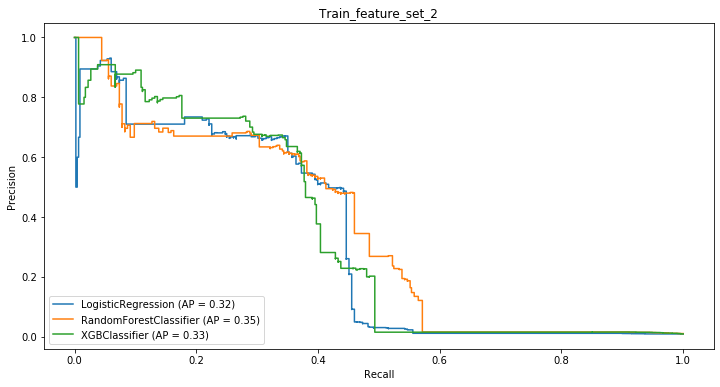

In [40]:
plot_pr_cuves(clf_list, x_test[feature_set_2], y_test,title = 'Train_feature_set_2')

### C. Features with non-zero value and the largest counts of corresponding positive examples.
1. These features could have good discriminating power.
3. Featureset_3 (6 of the features with the largest count of positive examples), modelling.
3. Worse performance compared to featureset 2, the interaction of these features shows that they're going along similar lines, without the cross interaction seen before. Just goes about near the threshold ?
4. Trying to model by combining the two feature sets.

In [46]:
for item in train.columns:
    try:
        print(item, train.loc[train[item]!= 0].Label.value_counts()[1])
    except KeyError:
        pass

week_start_date 1076
feature1 18
feature3 215
feature4 9
feature6 2
feature7 8
feature9 8
feature10 8
feature11 36
feature12 83
feature14 4
feature15 406
feature16 105
feature17 10
feature18 75
feature19 66
feature21 70
feature22 299
feature23 40
feature24 5
feature26 5
feature27 4
feature28 47
feature31 2
feature32 9
feature33 5
feature34 23
feature36 17
feature37 209
feature38 13
feature39 10
feature40 10
feature41 61
feature43 262
feature44 4
feature45 1
feature46 15
feature47 99
feature48 6
feature49 7
feature50 8
feature53 129
feature54 4
feature55 273
feature56 4
feature57 1
feature58 12
feature59 2
feature60 10
feature61 2
feature62 24
Label 1076


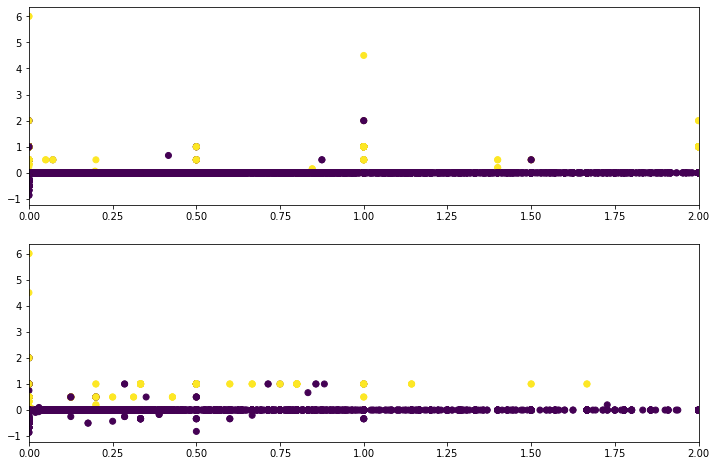

In [74]:
# try checking with 43, 3, 37 
fig, ax = plt.subplots(2, 1)
fig.set_figheight(8)
fig.set_figwidth(12)
ax[0].set_xlim(0,2)
ax[0].scatter(x = train['feature22'].values, y = train['feature15'].values, c = train.Label.values)
ax[1].set_xlim(0,2)
ax[1].scatter(x = train['feature55'].values, y = train['feature15'].values, c = train.Label.values)
plt.show()

In [28]:
feature_set_3 = ['feature15', 'feature22', 'feature55', 'feature43', 'feature3', 'feature37']
clf_log.fit(np.array(x_train[feature_set_3]), y_train)
clf_rf.fit(np.array(x_train[feature_set_3]), y_train)
xgb_clf.fit(np.array(x_train[feature_set_3]), y_train)
print(f'Logistic Regression - {f1_score(y_train, clf_log.predict(np.array(x_train[feature_set_3])))}')
print(f'Random Forest - {f1_score(y_train, clf_rf.predict(np.array(x_train[feature_set_3])))}')
print(f'XGBoost - {f1_score(y_train, xgb_clf.predict(np.array(x_train[feature_set_3])))}')

Logistic Regression - 0.4995780590717299
Random Forest - 0.35626283367556466
XGBoost - 0.39069316529326226


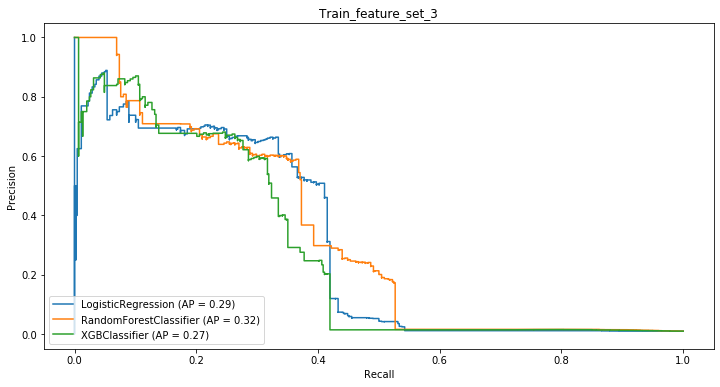

In [49]:
plot_pr_cuves(clf_list, x_test[feature_set_3], y_test,title = 'Train_feature_set_3')

## D. Combining Features Selected till now
1. Featureset 4, 13 selected features.
2. Also Adding a voting classifier ensemble classifier.
3. Similar performance to feature_set_2, slighlty higher precision in upper range of recall.

In [8]:
feature_set_4  = ['feature15','feature37','feature55','feature47','feature18','feature12',
                 'feature19','feature21','feature43','feature16','feature53','feature3','feature22']

In [51]:
vote_clf = VotingClassifier([('log_reg', clf_log), ('rf_clf', clf_rf), ('xgb_clf', xgb_clf)]
                            , voting='soft')
clf_list = [clf_log, clf_rf, xgb_clf, vote_clf]

clf_log.fit(np.array(x_train[feature_set_4]), y_train)
clf_rf.fit(np.array(x_train[feature_set_4]), y_train)
xgb_clf.fit(np.array(x_train[feature_set_4]), y_train)
vote_clf.fit(np.array(x_train[feature_set_4]), y_train)
print(f'Logistic Regression - {f1_score(y_train, clf_log.predict(np.array(x_train[feature_set_4])))}')
print(f'Random Forest - {f1_score(y_train, clf_rf.predict(np.array(x_train[feature_set_4])))}')
print(f'XGBoost - {f1_score(y_train, xgb_clf.predict(np.array(x_train[feature_set_4])))}')
print(f'VotingClassifier - {f1_score(y_train, vote_clf.predict(np.array(x_train[feature_set_4])))}')

Logistic Regression - 0.3921327596803934
Random Forest - 0.3905070118662352
XGBoost - 0.46988605534454697
VotingClassifier - 0.46063829787234045


In [52]:
y_pred = clf_log.predict(np.array(x_test[feature_set_4]))
y_pred_rf = clf_rf.predict(np.array(x_test[feature_set_4]))
y_pred_xgb = xgb_clf.predict(np.array(x_test[feature_set_4]))
y_pred_vclf = vote_clf.predict(np.array(x_test[feature_set_4]))
print(f1_score(y_test, y_pred))
print(f1_score(y_test, y_pred_rf))
print(f1_score(y_test, y_pred_xgb))
print(f1_score(y_test, y_pred_vclf))

0.3023431594860166
0.31513260530421217
0.33415637860082303
0.35708566853482787


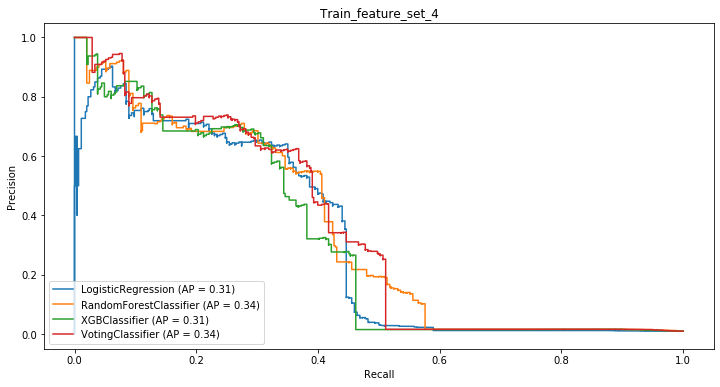

In [53]:
plot_pr_cuves(clf_list, x_test[feature_set_4], y_test,title = 'Train_feature_set_4')

# Final Precision-Recall Curves on provided test set Using Naive Approach
1. Training the models on entire training data.
2. Predicting for test data, only using labels for the evaluation.
3. XGBoost with all the features still appears to slighlty outperform the models when trained with featureset4, still that's a reduction of the used features from 62 to 13. Clearly these features are important for the classification.
4. Hyperparameter optimization next, other techniques, feature selection done for the most part.

In [82]:
# Change the featureset before and fit on new featureset before plotting curve.
featureset = feature_set_4

In [83]:
x_train = train[featureset]
y_train = train['Label']

In [84]:
x_test = test[featureset]
y_test = test['Label']

In [85]:
clf_log.fit(np.array(x_train[featureset]), y_train)
clf_rf.fit(np.array(x_train[featureset]), y_train)
xgb_clf.fit(np.array(x_train[featureset]), y_train)
vote_clf.fit(np.array(x_train[featureset]), y_train)
print(f'Logistic Regression - {f1_score(y_train, clf_log.predict(np.array(x_train[featureset])))}')
print(f'Random Forest - {f1_score(y_train, clf_rf.predict(np.array(x_train[featureset])))}')
print(f'XGBoost - {f1_score(y_train, xgb_clf.predict(np.array(x_train[featureset])))}')
print(f'VotingClassifier - {f1_score(y_train, vote_clf.predict(np.array(x_train[featureset])))}')

Logistic Regression - 0.47794117647058826
Random Forest - 0.26607445008460234
XGBoost - 0.4332566168009206
VotingClassifier - 0.4274678111587983


In [86]:
y_pred = clf_log.predict(np.array(x_test[featureset]))
y_pred_rf = clf_rf.predict(np.array(x_test[featureset]))
y_pred_xgb = xgb_clf.predict(np.array(x_test[featureset]))
y_pred_vclf = vote_clf.predict(np.array(x_test[featureset]))
print(f1_score(y_test, y_pred))
print(f1_score(y_test, y_pred_rf))
print(f1_score(y_test, y_pred_xgb))
print(f1_score(y_test, y_pred_vclf))

0.45226130653266333
0.26311541565778856
0.42189281641961235
0.41463414634146345


In [74]:
# Before Plotting please, make sure correct featureset selected.

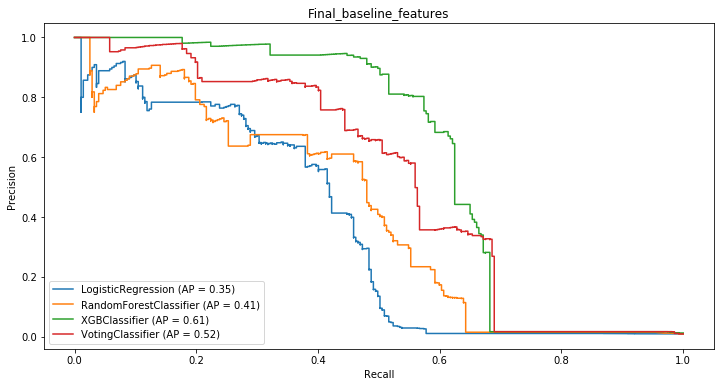

In [58]:
plot_pr_cuves(clf_list, x_test[baseline_features], y_test,title = 'Final_baseline_features')

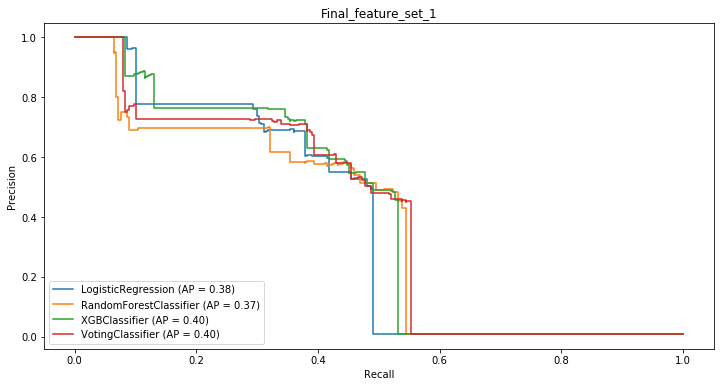

In [68]:
plot_pr_cuves(clf_list, x_test[feature_set_1], y_test,title = 'Final_feature_set_1')

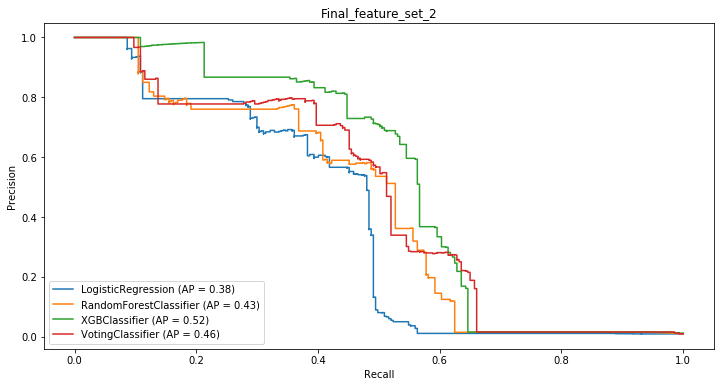

In [75]:
plot_pr_cuves(clf_list, x_test[feature_set_2], y_test,title = 'Final_feature_set_2')

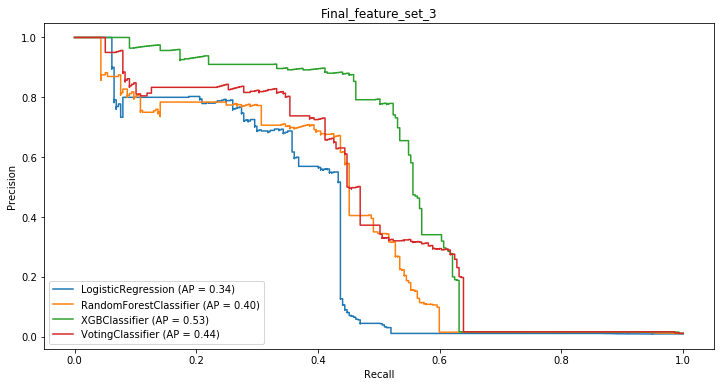

In [81]:
plot_pr_cuves(clf_list, x_test[feature_set_3], y_test,title = 'Final_feature_set_3')

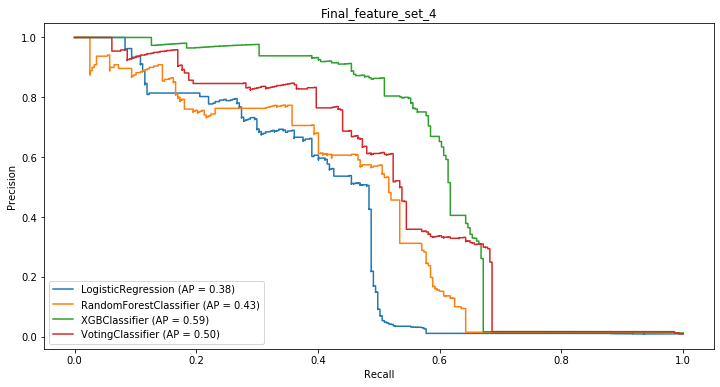

In [87]:
plot_pr_cuves(clf_list, x_test[feature_set_4], y_test,title = 'Final_feature_set_4')

## E. Simple ANN with 4 FC layers
Worse performance than tree based methods, loss saturated at a point. Fairly deep network for simple structured data. Overfits very easily after just 3 epochs.

In [103]:
# standardised data to get 0 mean, 1 std
scale = StandardScaler()

featureset = feature_set_4

x_train = train[featureset]
y_train = train['Label']

# One-hot encoded labels
dummy_labels = np_utils.to_categorical(y_train)

x_test = test[featureset]
y_test = test['Label']

x_train_scale = scale.fit_transform(x_train)
x_test_scale = scale.fit_transform(x_test)
class_weight = y_train.value_counts()[0]/y_train.value_counts()[1]

In [104]:
def base_model():
    model = Sequential()
    model.add(Dense(27, input_shape=(len(featureset),)))
    # Dropout regularization to prevent overfitting
    model.add(Dropout(rate = 0.4))
    model.add(Dense(27, activation = 'relu'))
    model.add(Dropout(rate = 0.4))
    model.add(Dense(27,  activation = 'relu'))
    model.add(Dropout(rate = 0.4))
    model.add(Dense(2, activation = 'sigmoid'))

# Learning parameters

    model.compile(optimizer = 'adam',
                 loss='binary_crossentropy',
                 metrics = ['accuracy'])
    
    return model

In [112]:
model_ann = base_model()
model_ann.fit(x_train_scale, dummy_labels, batch_size = 32, epochs = 3, class_weight = {0:1, 1:class_weight})

Epoch 1/3
114706/114706 [==============================] - 16s 139us/step - loss: 1.2339 - accuracy: 0.9278
Epoch 2/3
114706/114706 [==============================] - 16s 139us/step - loss: 1.0425 - accuracy: 0.9836
Epoch 3/3
114706/114706 [==============================] - 16s 139us/step - loss: 1.0279 - accuracy: 0.9829


In [113]:
y_pred = model_ann.predict_classes(x_test_scale)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99     29343
           1       0.42      0.54      0.48       277

    accuracy                           0.99     29620
   macro avg       0.71      0.77      0.74     29620
weighted avg       0.99      0.99      0.99     29620



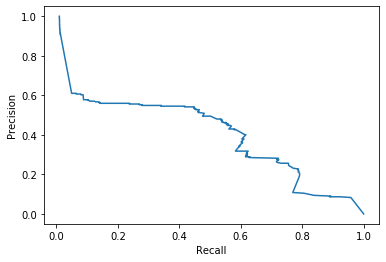

In [114]:
# Plotting precision-Recall on Test Set.
y_pred_proba = model_ann.predict_proba(x_test_scale)
pred_curve = precision_recall_curve(y_test, y_pred_proba[:,1])
plt.plot(pred_curve[0], pred_curve[1])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

## 2. Time-Series Approach - Exploring overall Time-Series and by Account ID.
1. The data can be though of as 62 simultaneous time-series, for each feature,for each account. 
2. The time-series are different lengths, makes sense for different customers joining/leaving at different times. Is a problem, looking at a single account first and also how the label acts over all accounts over time.
3. Plot the number of positive labels for the time series, overlay with the number of unique accounts then. See if spike, seasonality etc. (Done)
4. Plot the time series for featuresets from above. (Done)

#### Overall Time-Series : Number of Accounts and Interventions over time
1. There doesn't appear to be any relationship between the growth in the number of accounts, and the number of interventions. One problem is that the cumulative sum includes duplicate accounts. Plotting the change in accounts seems to show a relationship between the two. Statistically significant, strong linear relationship according to pearsons correlation coefficient.
2. Bi-yearly seasonality looks to be present in the number of interventions required.

In [229]:
# Reloading, cannot index by account id, groupby isn't working as expected.
train = pd.read_csv('Train_Set.csv')
test = pd.read_csv('Test_Set.csv')

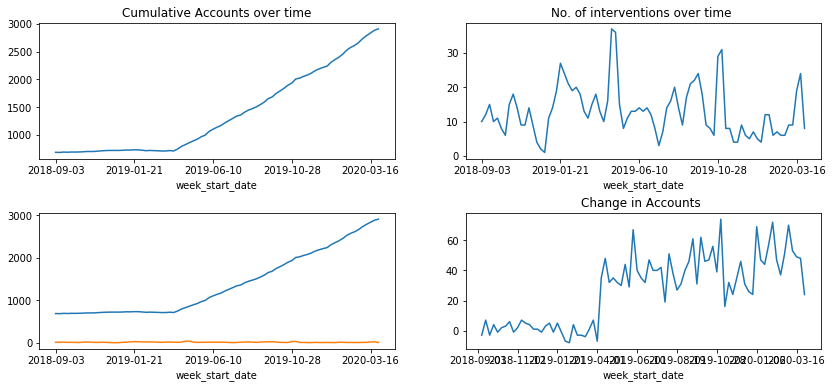

In [246]:
fig, ax = plt.subplots(2, 2, figsize = (14, 6))
plt.subplots_adjust(hspace = 0.4)
train.groupby(['week_start_date'])['account_id'].count().plot(kind = 'line', ax = ax[0,0])
ax[0,0].set_title('Cumulative Accounts over time')
train.groupby(['week_start_date'])['Label'].sum().plot(ax = ax[0,1])
ax[0,1].set_title('No. of interventions over time ')
train.groupby(['week_start_date'])['account_id'].count().plot(kind = 'line', ax = ax[1,0])
train.groupby(['week_start_date'])['Label'].sum().plot(ax = ax[1,0])
change = (temp.groupby(['week_start_date'])['account_id'].count() - 
          temp.groupby(['week_start_date'])['account_id'].count().shift(1))
change.plot(kind = 'line', ax = ax[1,1])
ax[1,1].set_title('Change in Accounts ')
plt.show()

In [224]:
pearsonr(train.groupby(['week_start_date'])['account_id'].count()[1:].values, change.values[1:])

(0.7077372820234344, 1.0515141605376794e-13)

Comparing the trend and any spike in positive labels, and the sum of the values of the features, there doesn't seem to be much correlation except for what was seen in the correlation heatmap.

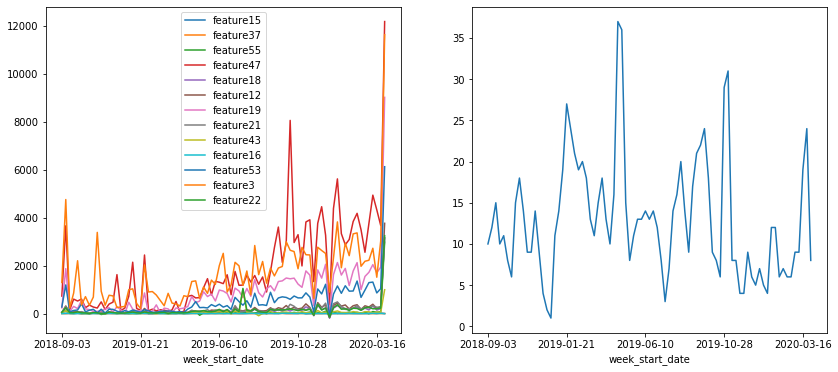

In [263]:
fig, ax = plt.subplots(1, 2, figsize = (14, 6))

for item in feature_set_4:
    train.groupby(['week_start_date'])[item].sum().plot(legend = True, ax = ax[0])
    
train.groupby(['week_start_date'])['Label'].sum().plot(ax = ax[1])
plt.show()

#### Account Wise Time-Series

In [232]:
# Accounts with most sample points. 
train['account_id'].value_counts()

104959.0    280
105810.0    278
109056.0    278
100618.0    274
102171.0    272
           ... 
100796.0      1
187594.0      1
101642.0      1
239954.0      1
239955.0      1
Name: account_id, Length: 2690, dtype: int64

Difficult to pin-point any obvious relationship between a features value and the label just by looking at the data. 

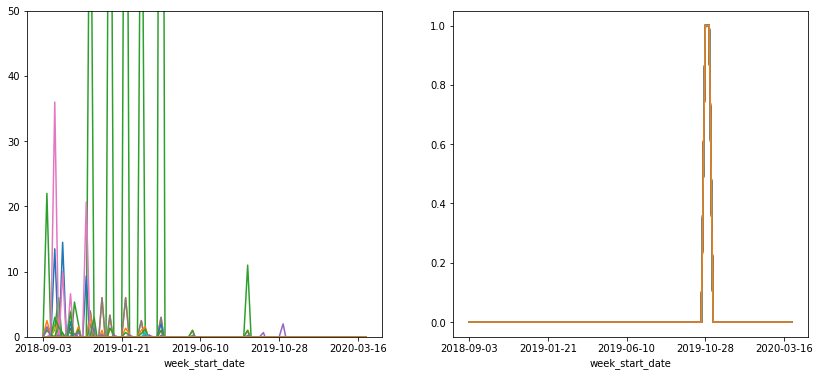

In [284]:
temp = train.loc[train['account_id'] == 104959.0]
fig, ax = plt.subplots(1, 2, figsize = (14, 6))
for item in baseline_features:
    temp.groupby(['week_start_date'])[item].sum().plot(legend = False, ax = ax[0], ylim = (0, 50))
    temp.groupby(['week_start_date'])['Label'].max().plot()

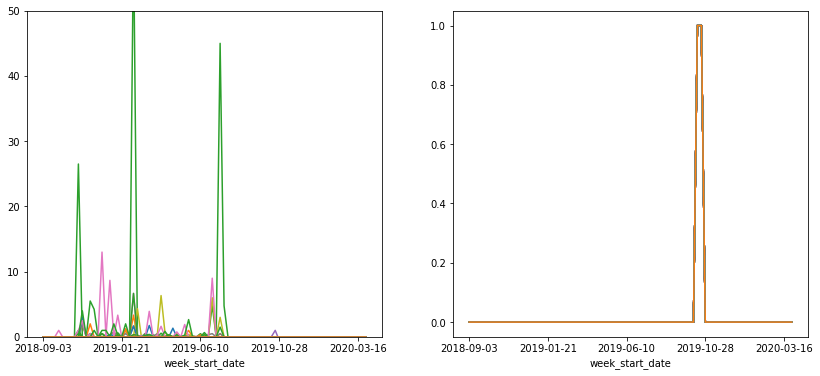

In [288]:
temp = train.loc[train['account_id'] == 105810.0]
fig, ax = plt.subplots(1, 2, figsize = (14, 6))
for item in baseline_features:
    temp.groupby(['week_start_date'])[item].max().plot(legend = False, ax = ax[0], ylim = (0, 50))
    temp.groupby(['week_start_date'])['Label'].max().plot()

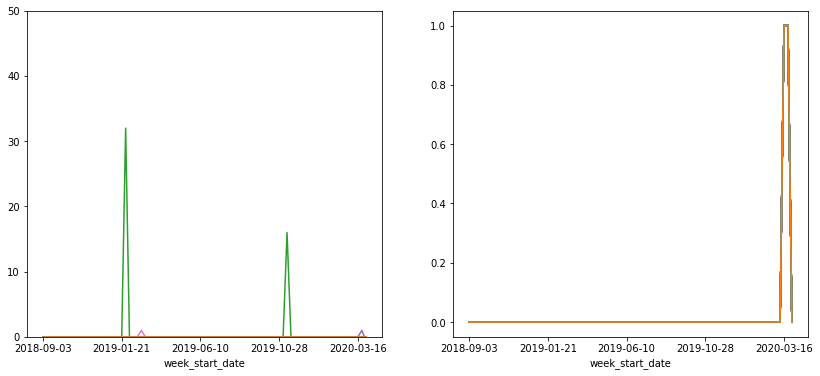

In [289]:
temp = train.loc[train['account_id'] == 109056.0]
fig, ax = plt.subplots(1, 2, figsize = (14, 6))s
for item in baseline_features:
    temp.groupby(['week_start_date'])[item].max().plot(legend = False, ax = ax[0], ylim = (0, 50))
    temp.groupby(['week_start_date'])['Label'].max().plot()